<a href="https://colab.research.google.com/github/dudeurv/SAM_MRI/blob/main/UNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation with U-NET


In [9]:
# Import libraries
import tarfile
import imageio as iio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## Download the imaging dataset

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/).
The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:
- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-11-30 16:54:59--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-11-30 16:54:59--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc1dde285aa3cd311b1d373b4d2.dl.dropboxusercontent.com/cd/0/inline/CIimSziDwrRs46Jckd8nD1ehWeSlq3-Mvoj-pnbAT9R6qrYpfQpGT-tAJGTrsfl2LAQP3tEIqt1eO1RMHqgHv3xR7bu4OYM3ELDylaKZ5aBeddFkO0m0a5G62Q9gGITDldc/file# [following]
--2023-11-30 16:54:59--  https://ucc1dde285aa3cd311b1d373b4d2.dl.dropboxusercontent.com/cd/0/inline/CIimSziDwrRs46Jckd8nD1ehWeSlq3-Mvoj-pnbAT9R6qrYpfQpGT-tAJGTrsfl2LAQP3tEI

# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [3]:
def normalise_intensity(image, ROI_thres=0.1):
    """
    The function identifies the ROI in the image by applying a percentile-based threshold,
    then standardizes the pixel values in this region by subtracting the mean and dividing
    by the standard deviation.

    Args:
        image (np.array): Input image as a NumPy array.
        ROI_thres (float): Percentile threshold for defining the ROI (default is 0.1).

    Returns:
        np.array: Image array with normalized intensity in the ROI.
    """
    pixel_thres = np.percentile(image, ROI_thres)
    ROI = np.where(image > pixel_thres, image, 0) # If image value is greater than pixel threshold, return image value, otherwise return 0
    mean = np.mean(ROI)
    std = np.std(ROI)
    ROI_norm = (ROI - mean)/std # Normalise ROI
    return ROI_norm

class BrainImageSet():
    def __init__(self, image_path, label_path, deploy=False):
      # Initialise instant variables
      self.image_path = image_path
      self.label_path = label_path
      self.deploy = deploy # If deploy=True this means model is in testing mode
      self.images = [] # List of loaded image arrays
      self.labels = [] # List of loaded label arrays

      image_names = sorted(os.listdir(image_path)) # Sorted list containing image filenames to ensure a consistent order for data processing.
      for image_name in image_names:
        full_image_path = os.path.join(image_path, image_name)
        image = iio.imread(full_image_path) # Loads image into a processable NumPy array.
        self.images.append(image)

        if deploy == False: # If model is in training mode, load the labels as well
          full_label_path = os.path.join(label_path, image_name)
          label = iio.imread(full_label_path)
          self.labels.append(label)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        image = normalise_intensity(self.images[idx])

        # Get its label map
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        images_batch, labels_batch = [], []

        idx_array = range(0, len(self.images)) # Creates an array of indices ranging from 0 to len(self.images)
        batch_idx = random.sample(idx_array, batch_size) # Randomly selects a batch_size number of indices
        for i in range(batch_size):
            image, label = self.__getitem__(batch_idx[i])
            images_batch.append(image)
            labels_batch.append(label)

        images_batch, labels_batch = np.array(images_batch), np.array(labels_batch)
        images_batch = np.expand_dims(images_batch, 1)
        return images_batch, labels_batch

# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [4]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    # Convolution layer, a ReLU activation to add non-linearity, and Batch Normalisation
    # Bias is set as false, as Batch Normalisation would remove the bias
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  # U-Net Model involves an encoder, a bottleneck and decoder section
  def __init__(self):
    super().__init__()
    # Encoder with 4 blocks of Double_Convolution layers
    # Includes 4 sets of max pooling operations with kernel 2x2 and stride 2 for downsampling
    self.down_1 = nn.Sequential(
        conv_block(1, 16),
        conv_block(16, 16),
    )
    self.down_2 = nn.Sequential(
        conv_block(16, 32, 2),
        conv_block(32, 32),
    )
    self.down_3 = nn.Sequential(
        conv_block(32, 64, 2),
        conv_block(64, 64),
    )
    # Bottleneck
    # Includes a Double Convolution layer followed by upsampling with ConvTranspose2d
    self.bottle = nn.Sequential(
        conv_block(64, 128, 2),
        conv_block(128, 128),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
    )

    # Decoder
    # Concatinating with skip connections causes feature channels to double
    # Double_Convolution and ConvTranspose2d each causes feature channels to halve
    self.up_1 = nn.Sequential(
        conv_block(128, 64),
        conv_block(64, 64),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    self.up_2 = nn.Sequential(
        conv_block(64, 32),
        conv_block(32, 32),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
    )
    # Final Output Layer
    self.out = nn.Sequential(
        conv_block(32, 16),
        conv_block(16, 16),
        nn.Conv2d(16, 4, kernel_size=1, padding=0)
    )

  def forward(self, x):
      # Use the convolutional operators defined above to build the U-net
      # Encoder
      x1 = self.down_1(x)
      x2 = self.down_2(x1)
      x3 = self.down_3(x2)

      x4 = self.bottle(x3)

      # Decoder
      ### Insert your code ###
      x5 = torch.cat((x4, x3), dim=1)
      x6 = self.up_1(x5)
      x7 = torch.cat((x6, x2), dim=1)
      x8 = self.up_2(x7)
      x9 = torch.cat((x8, x1), dim=1)
      x10 = self.out(x9)
      return x10


# Train the segmentation model

In [6]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
model = UNet()
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
loss_fn = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
epochs = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for epoch in range(epochs):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Fetch a batch of training data and transfer it to the device
    train_images, train_labels = train_set.get_random_batch(train_batch_size)
    train_images, train_labels = torch.from_numpy(train_images), torch.from_numpy(train_labels)
    train_images, train_labels = train_images.to(device, dtype=torch.float32), train_labels.to(device, dtype=torch.long)

    # Perform a forward pass through the model
    model_labels = model(train_images)

    # Note that optimizer.zero_grad() is equivalent to net.zero_grad() if it optimises all the net parameters.
    optimizer.zero_grad()

    optimizer.zero_grad() # Clear previous gradients
    loss = loss_fn(model_labels, train_labels) # Compute loss
    loss.backward() # Carry out backpropagation and calculate gradients
    optimizer.step() # Update model parameters

    # Evaluate
    if epoch % 2000 == 0:
        print('--- Epoch {0}: Training loss = {1:.4f}, {2:.4f} s ---'.format(epoch, loss.item(), time.time() - start_iter))
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
            test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)

            pred_labels = model(test_images)

            test_loss = loss_fn(pred_labels, test_labels)
            print('--- Epoch {0}: Test loss = {1:.4f} ---\n'.format(epoch, test_loss.item()))

    # Save the model
    if epoch % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(epoch)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-3-f5612894b15e>:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(full_image_path) # Loads image into a processable NumPy array.
<ipython-input-3-f5612894b15e>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = iio.imread(full_label_path)


--- Epoch 0: Training loss = 1.0804, 0.0675 s ---
--- Epoch 0: Test loss = 1.1453 ---

--- Epoch 2000: Training loss = 0.0263, 0.0651 s ---
--- Epoch 2000: Test loss = 0.0387 ---

--- Epoch 4000: Training loss = 0.0256, 0.0638 s ---
--- Epoch 4000: Test loss = 0.0301 ---

--- Epoch 6000: Training loss = 0.0165, 0.0652 s ---
--- Epoch 6000: Test loss = 0.0442 ---

--- Epoch 8000: Training loss = 0.0085, 0.0665 s ---
--- Epoch 8000: Test loss = 0.0351 ---

Training took 379.702s in total.


# Visualise the segmentation results

In [7]:
# Get a random batch of test images
# Segment the images using the trained model
images, labels = test_set.get_random_batch(4)
images, labels = torch.from_numpy(images), torch.from_numpy(labels)
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
model.eval()
logits = model(images)
prob = F.softmax(logits, dim=1)
seg = torch.argmax(prob, dim=1)

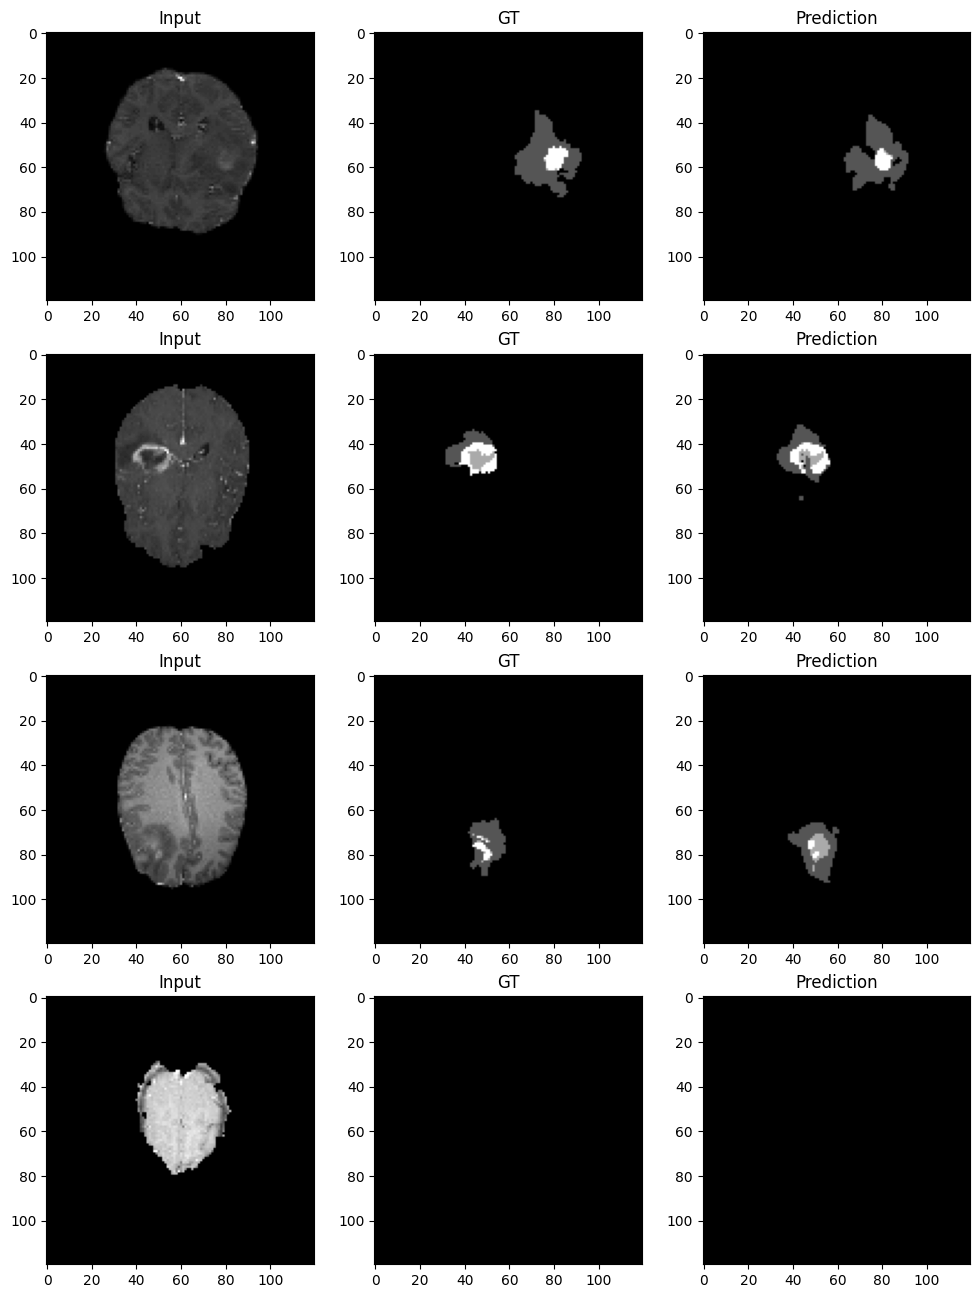

In [8]:
# Visualise the image, automated segmentation and manual segmentation
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
### Insert your code ###
for i in range(4):
    axs[i,0].imshow(images[i,0].cpu(), cmap='gray')
    axs[i,0].set_title('Input')
    axs[i,1].imshow(labels[i].cpu(), cmap='gray')
    axs[i,1].set_title('GT')
    axs[i,2].imshow(seg[i].cpu(), cmap='gray')
    axs[i,2].set_title('Prediction')
### End your code ###